In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pymongo
import pandas as pd
from pymongo import MongoClient

Tworzenie ramki danych

In [2]:
#wczytanie danych z mongodb
client = MongoClient()
db = client.twitter
collection = db.tweet_info
data = pd.DataFrame(list(collection.find()))
        
        
    

In [4]:
#tworzenie ramki danych
data= data.drop(columns=['text', '_id','subjectivity','location'])
data = data.astype({"sentiment": float})

conditions = [
    (data['sentiment'] > 0),
    (data['sentiment'] == 0),
    (data['sentiment'] < 0)
    ]
values = ['positive', 'neutral', 'negative']
data_pos=data
data_pos['sent'] = np.select(conditions, values)

data_pos=data_pos[data_pos.sent != 'negative']
data_pos=data_pos[data_pos.sent != 'neutral']
data_pos=data_pos.groupby('keyword').count()
data_pos = data_pos.drop('sent', 1)
data_pos = data_pos.rename({'sentiment':'pos_count'}, axis='columns')

In [5]:
data=data.groupby('keyword')['sentiment'].agg(['mean','count'])
rating=pd.read_csv('movies.csv')
rating = rating.rename({'primaryTitle': 'keyword'}, axis='columns')
movies=pd.merge(rating, data, on=["keyword"])
movies=pd.merge(movies, data_pos, on=["keyword"])
movies = movies.rename({'mean':'sentiment','count':'tweet_num'}, axis='columns')

In [6]:
movies['pos_percentage']=movies['pos_count']/movies['tweet_num']
movies = movies.drop('pos_count', 1)

Wizualizcja

In [8]:
movies_rating_sort= movies.sort_values('averageRating',ascending=True)
movies_sentiment_sort= movies.sort_values('sentiment',ascending=True)
movies_pos_percentage_sort= movies.sort_values('pos_percentage',ascending=True)

Text(0.5, 1.0, 'Average rating')

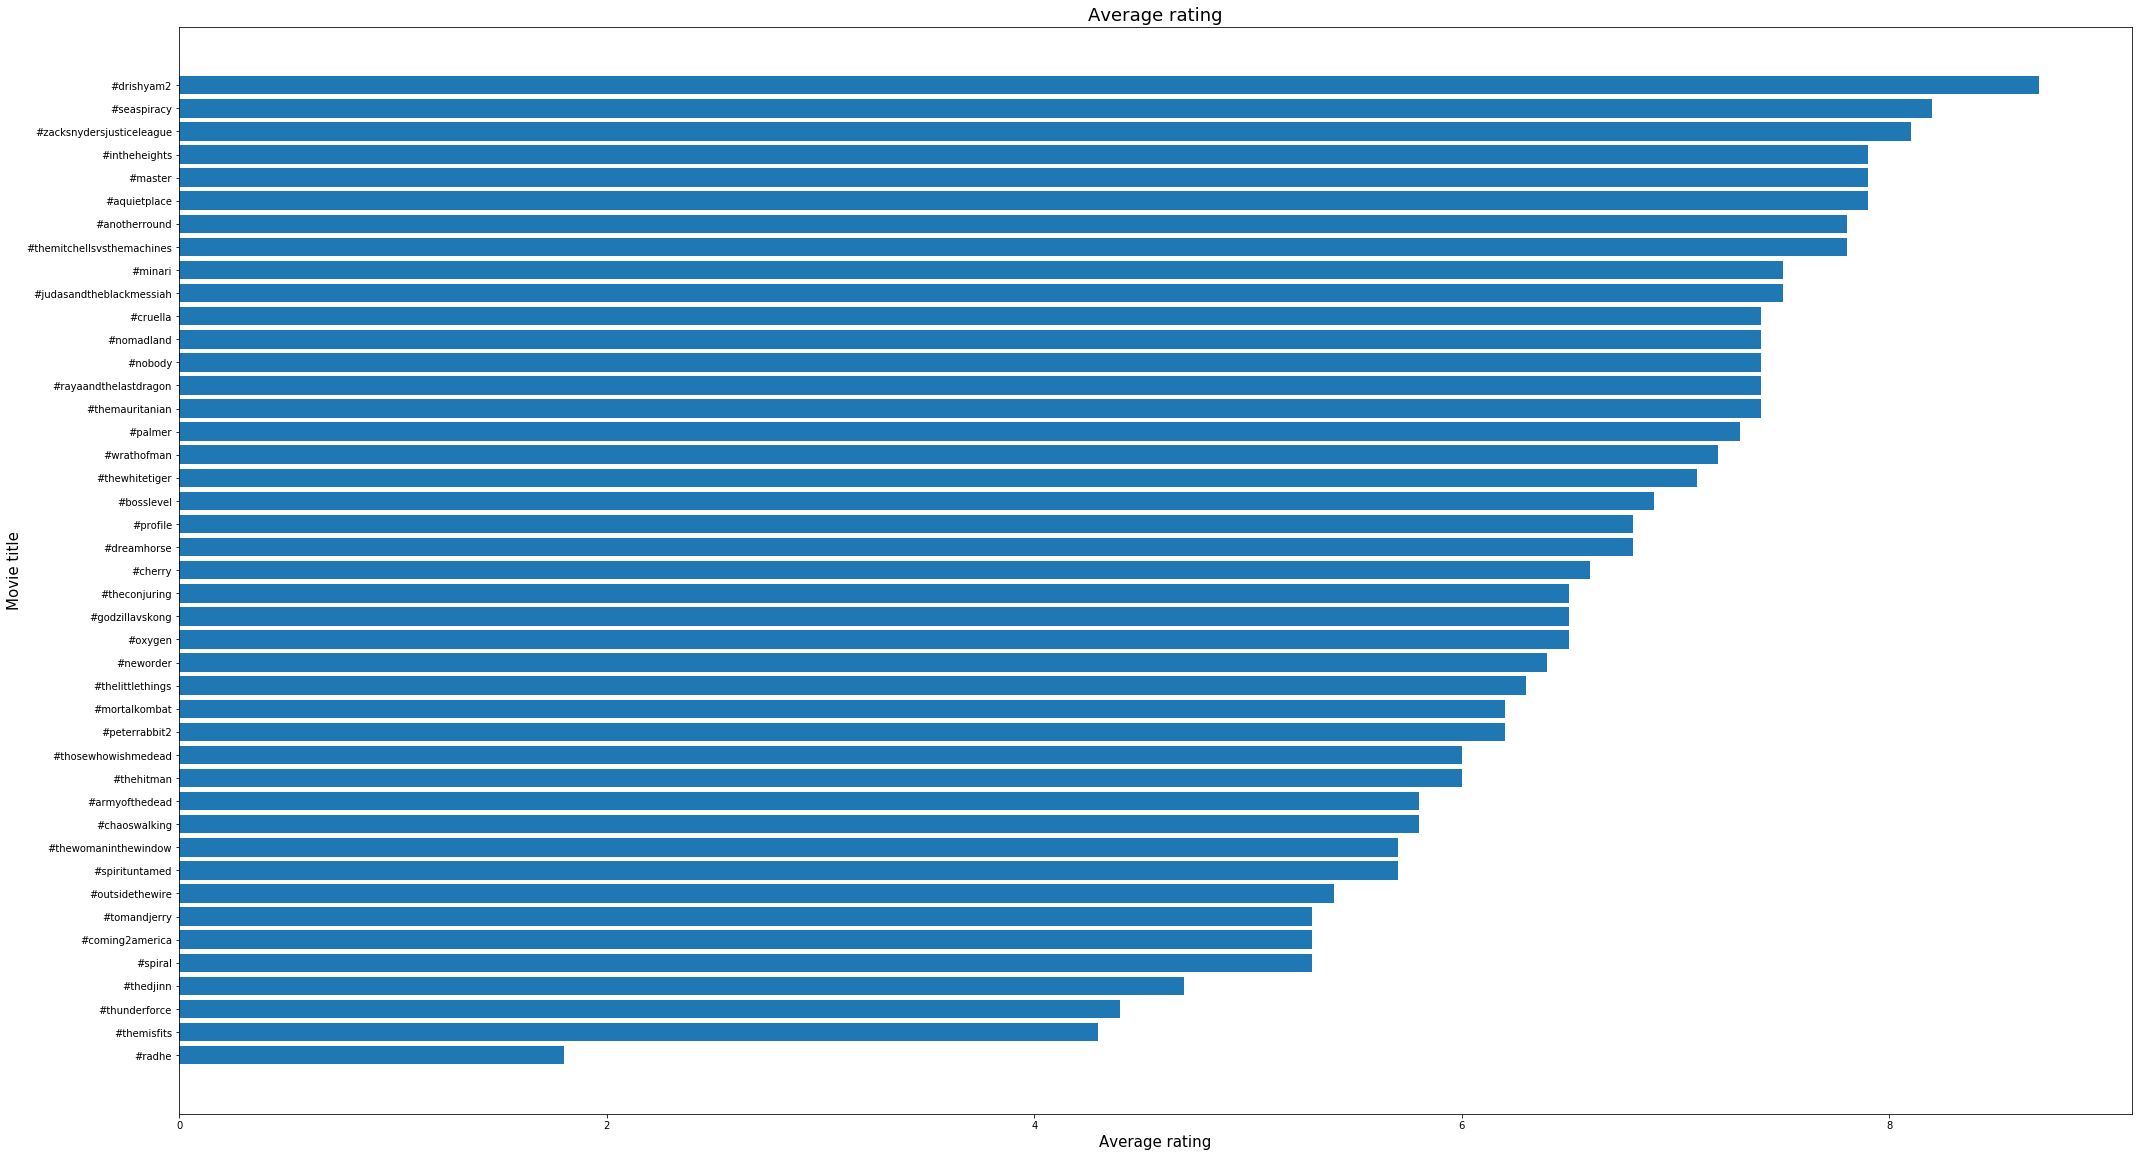

In [9]:
plt.figure(figsize=(35,20))
plt.barh('keyword', 'averageRating',data=movies_rating_sort)
plt.xlabel("Average rating", size=15)
plt.ylabel("Movie title", size=15)
plt.title("Average rating", size=18)

Text(0.5, 1.0, 'Sentiment')

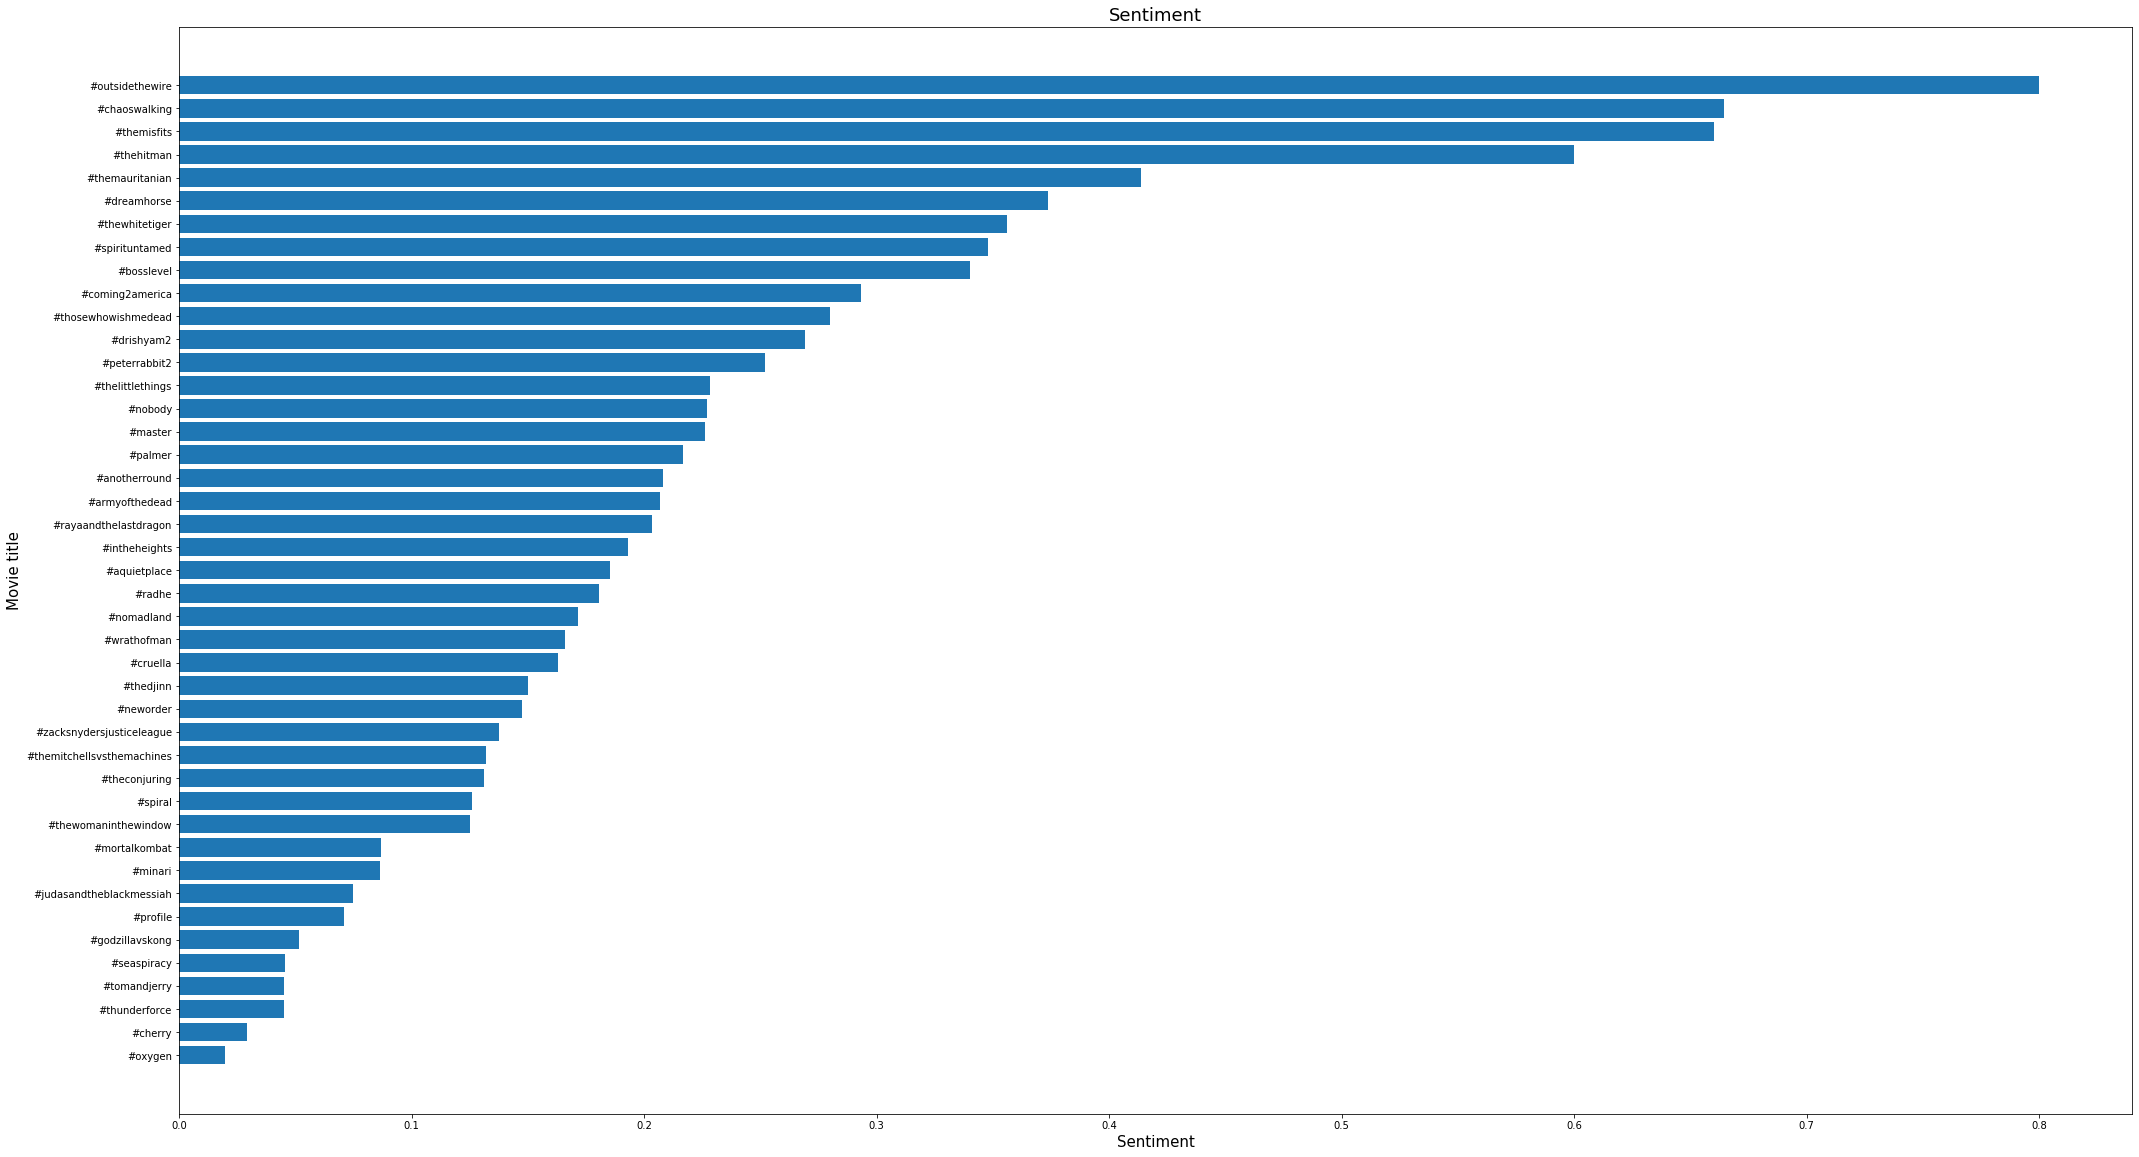

In [10]:
plt.figure(figsize=(35,20))
plt.barh('keyword', 'sentiment',data=movies_sentiment_sort)
plt.xlabel("Sentiment", size=15)
plt.ylabel("Movie title", size=15)
plt.title("Sentiment", size=18)

Text(0.5, 1.0, 'Posistive percentage ')

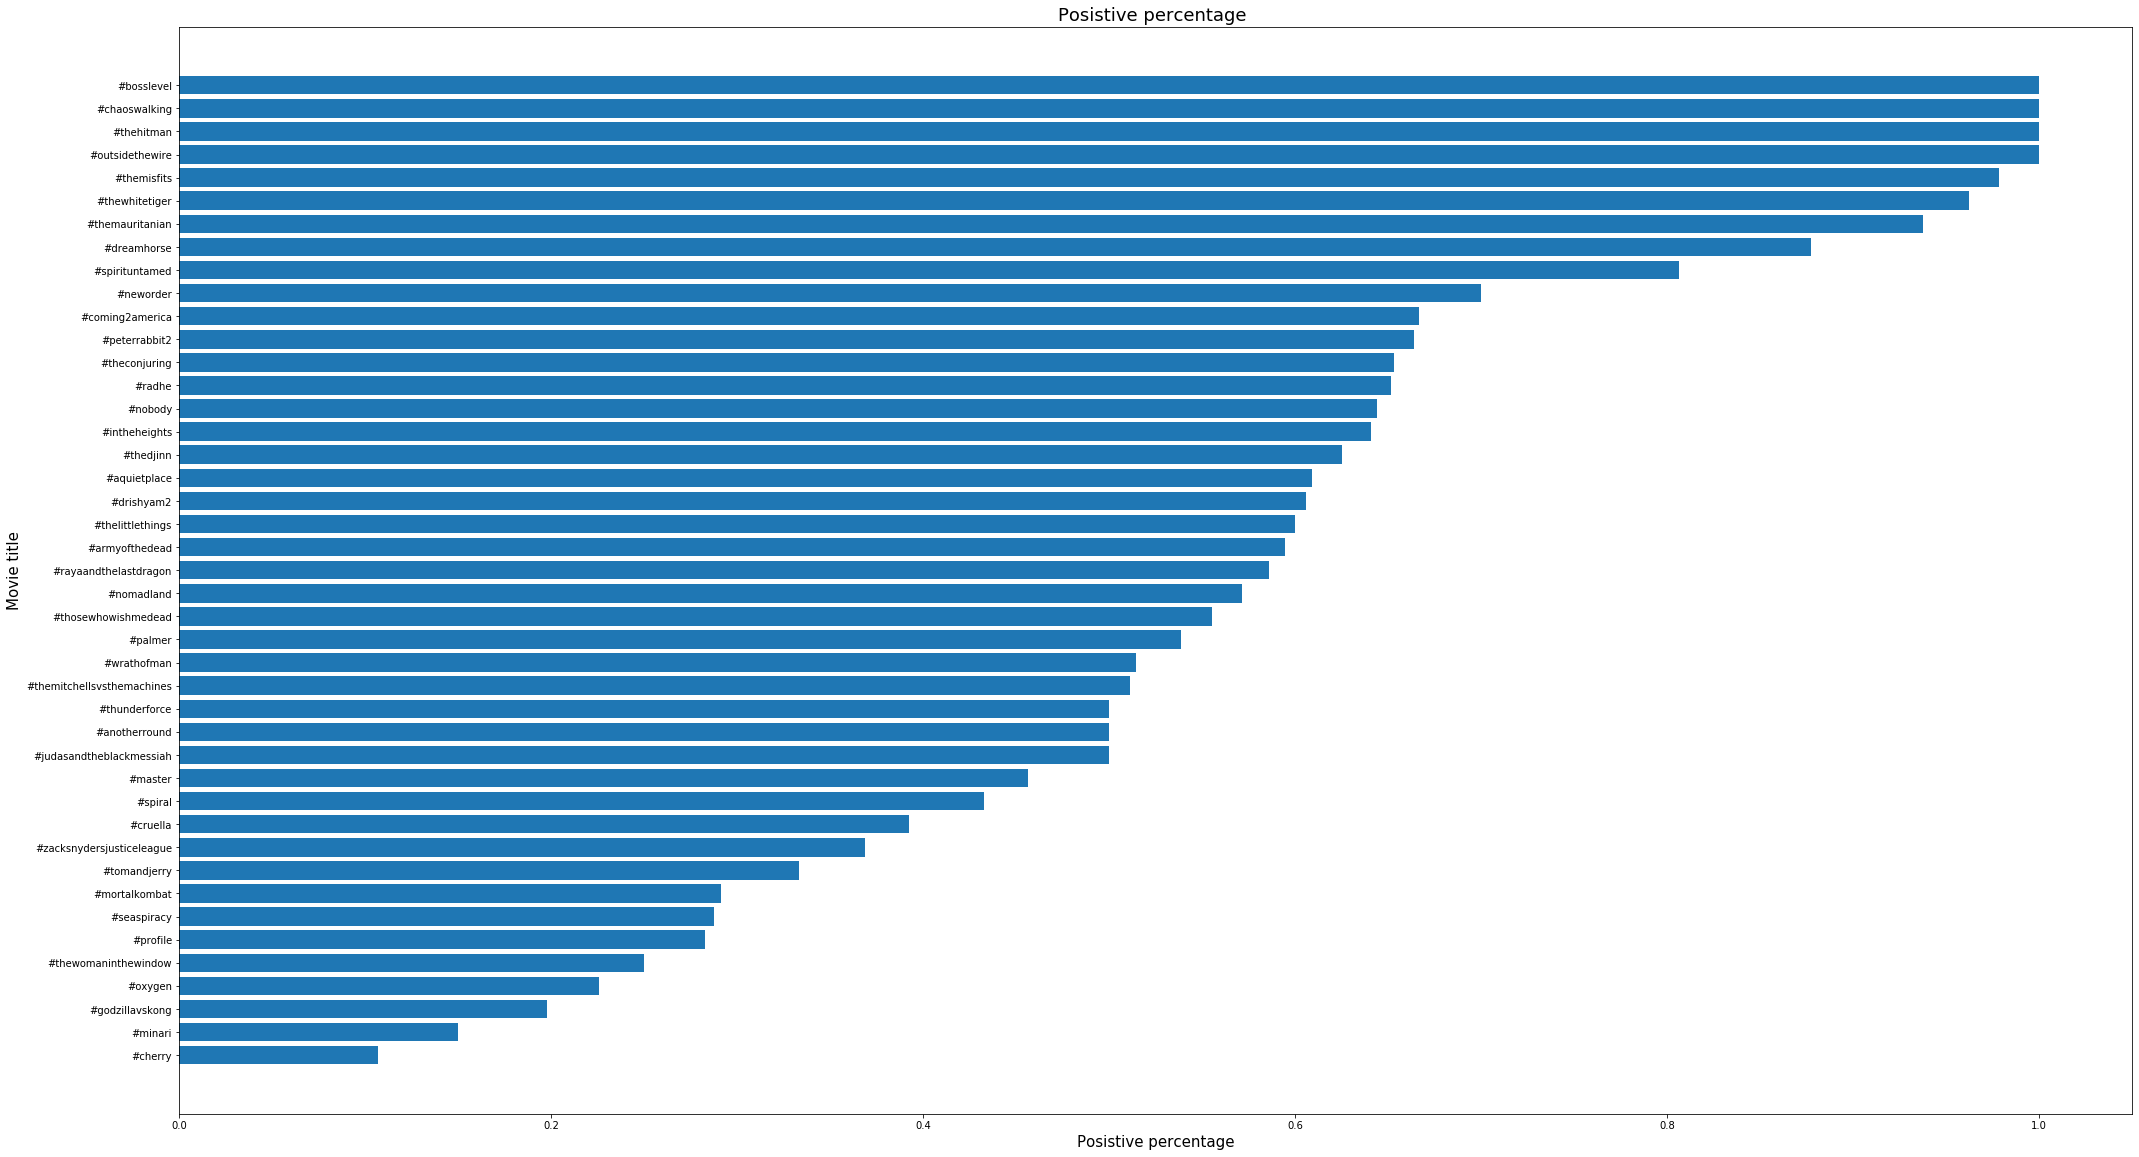

In [11]:
plt.figure(figsize=(35,20))
plt.barh('keyword', 'pos_percentage',data=movies_pos_percentage_sort)
plt.xlabel("Posistive percentage", size=15)
plt.ylabel("Movie title", size=15)
plt.title("Posistive percentage ", size=18)


Modyfikacje

In [12]:
#czyszczenie danych
#usunięcie hinduskich filmów
#movies=movies[movies.keyword != '#thewhitetiger']
#movies=movies[movies.keyword != '#drishyam2']
#movies=movies[movies.keyword != '#master']


#movies=movies[movies.keyword != '#chaoswalking']

movies = movies.drop(movies[movies.tweet_num < 10].index)
movies = movies.drop(movies[movies.averageRating < 5].index)

#usuniecie filmów o liczbie tweetów <50
#movies = movies.drop(movies[movies.tweet_num < 50].index)



scaler = MinMaxScaler()
movies[['averageRating', 'sentiment','pos_percentage']] = scaler.fit_transform(movies[['averageRating', 'sentiment','pos_percentage']])
movies[['averageRating']] = scaler.fit_transform(movies[['averageRating']])

Korelacja

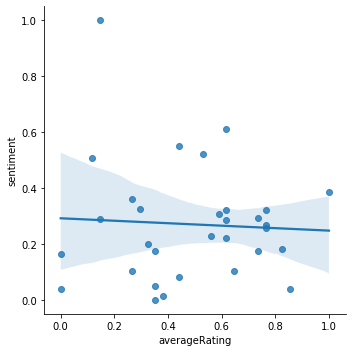

In [13]:

sns.lmplot(x="averageRating", y="sentiment", data=movies);

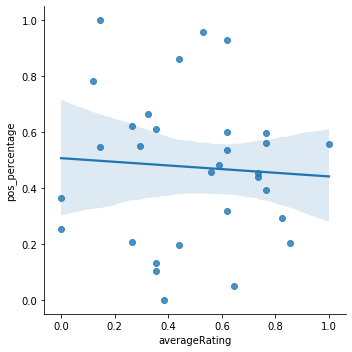

In [14]:

sns.lmplot(x="averageRating", y="pos_percentage", data=movies);

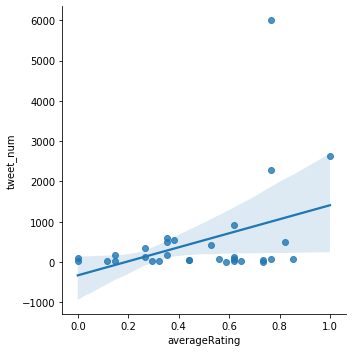

In [15]:

sns.lmplot(x="averageRating", y="tweet_num", data=movies);

In [16]:
cormat = movies.corr()
round(cormat,2)

,averageRating,sentiment,tweet_num,pos_percentage
averageRating,1.00,-0.06,0.38,-0.06
sentiment,-0.06,1.00,0.02,0.88
tweet_num,0.38,0.02,1.00,-0.07
pos_percentage,-0.06,0.88,-0.07,1.00
